In [3]:
import dask.dataframe as dd
import pandas as pd
import ray.dataframe as rd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import dask.dataframe as dd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [4]:
os.chdir("/Users/bshao/Desktop/lending club")

In [5]:
df = pd.read_csv("LoanStats3d.csv",sep=",",encoding="latin-1")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (17,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df = df[df.loan_status != 'Current']

In [7]:
df.reset_index(drop=True, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Columns: 143 entries, loan_amnt to settlement_term
dtypes: float64(66), int64(40), object(37)
memory usage: 459.4+ MB


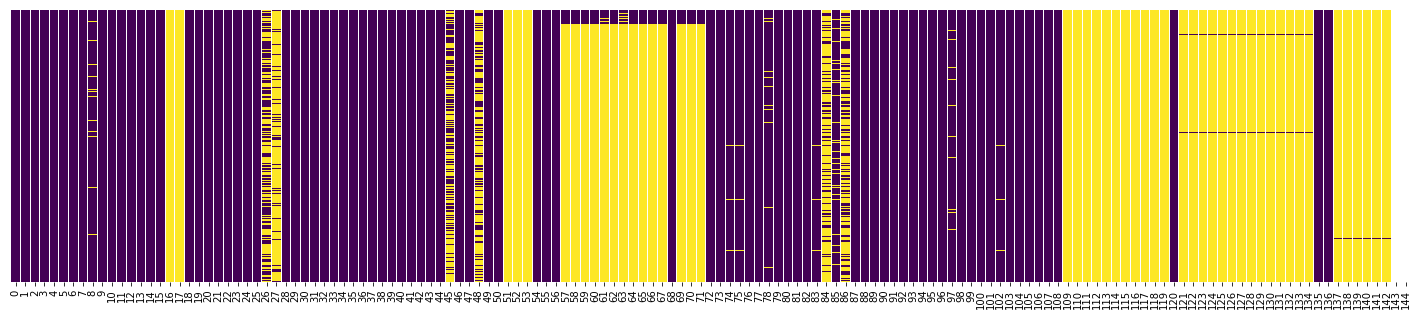

In [86]:
plt.figure(figsize=(25,5)) 
sns.set_context(font_scale=10)   
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',xticklabels=list(range(143)))

#### Find and filter out the features that have more 50% of missing value

In [8]:
df.revol_util.fillna(-999,inplace=True)
df.revol_util=df.revol_util.str[:-1]

In [9]:
# remove units
df.int_rate=df.int_rate.str[:-1]
#df.revol_util=df.revol_util.str[:-1]
df.term=df.term.str[:3]

df.loc[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years'),'emp_length']=df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')].str[:-6]
df.loc[df.emp_length=='< 1 year','emp_length']=df.emp_length[df.emp_length=='< 1 year'].str[:-5]
df.loc[df.emp_length=='1 year','emp_length']=df.emp_length[df.emp_length=='1 year'].str[:-5]
df.loc[df.emp_length=='10+ years','emp_length']=df.emp_length[df.emp_length=='10+ years'].str[:-7]
# '<1 year'-->0, '10+ years'-->10
df.loc[df.emp_length=='< 1','emp_length']=0
df.loc[df.emp_length=='','emp_length']=np.nan

# keep first 3 digit of zipcode
df.zip_code=df.zip_code.str[:-2]

In [10]:
# good loans(0) and bad loan(1) 
df.loan_status.value_counts()

Fully Paid            183593
Charged Off            62042
Late (31-120 days)      5485
In Grace Period         2943
Late (16-30 days)       1033
Default                   22
Name: loan_status, dtype: int64

In [11]:
# good loans(0) and bad loan(1) 
df['label']='0'
df.loc[df.loan_status.isin(['Charged Off','Late (31-120 days)','Default']),'label']='1'

In [12]:
# transform date into duration (in years)
earl_d=df.earliest_cr_line
earl_y=[datetime.strptime(x,'%b-%y').year for x in earl_d]
df['dur_y']=np.repeat(2015,len(earl_y))-earl_y

In [13]:
df.fillna(-999,inplace=True)

In [14]:
l_int=['loan_amnt','term','emp_length','zip_code','delinq_2yrs','inq_last_6mths',
      'mths_since_last_delinq','open_acc','pub_rec','revol_bal','total_acc','acc_now_delinq','tot_coll_amt',
      'tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal', 'bc_open_to_buy','chargeoff_within_12_mths', 
       'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl','mort_acc', 
       'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl','num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
       'num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m','pub_rec_bankruptcies','tax_liens', 
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','total_il_high_credit_limit','dur_y']
l_float=['int_rate','annual_inc','installment','dti','revol_util','bc_util','pct_tl_nvr_dlq', 'percent_bc_gt_75']
l_object=['grade', 'sub_grade', 'emp_title', 'home_ownership','verification_status', 'loan_status', 'purpose', 'title', 
          'addr_state','earliest_cr_line', 'initial_list_status', 'application_type','disbursement_method', 'label']

In [15]:
for i in l_int:
    df[i]=df[i].astype(int)
for i in l_float:
    df[i]=df[i].astype(float)
for i in l_object:
    df[i]=df[i].astype(object)

In [16]:
len(l_float)+len(l_int)+len(l_object)

69

In [17]:
df = df[l_int+l_float+l_object]

In [18]:
dff=df.drop(['loan_status','earliest_cr_line'],axis=1)

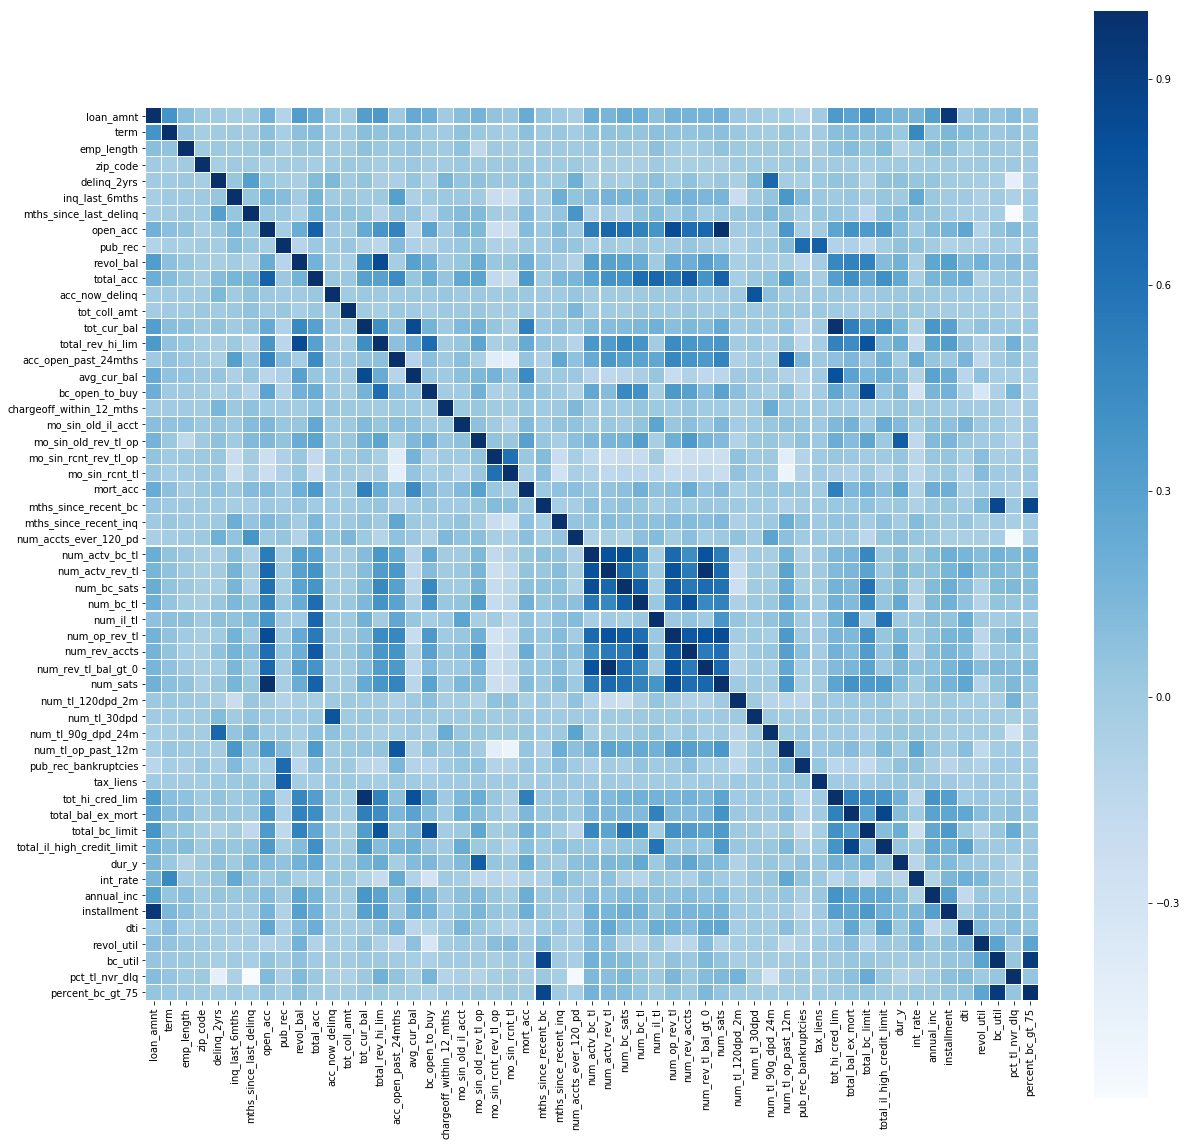

In [16]:
corr=dff.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap=plt.cm.Blues,square=True,annot_kws={'size':8},linewidths=0.1)

In [19]:
ll_object=['grade', 'sub_grade', 'home_ownership', 'addr_state', 'initial_list_status', 'application_type',
           'verification_status', 'purpose', 'title','emp_title']

In [20]:
#there is only one vaue "cash" for 'disbursement_method'
dff.drop('disbursement_method',axis=1,inplace=True)

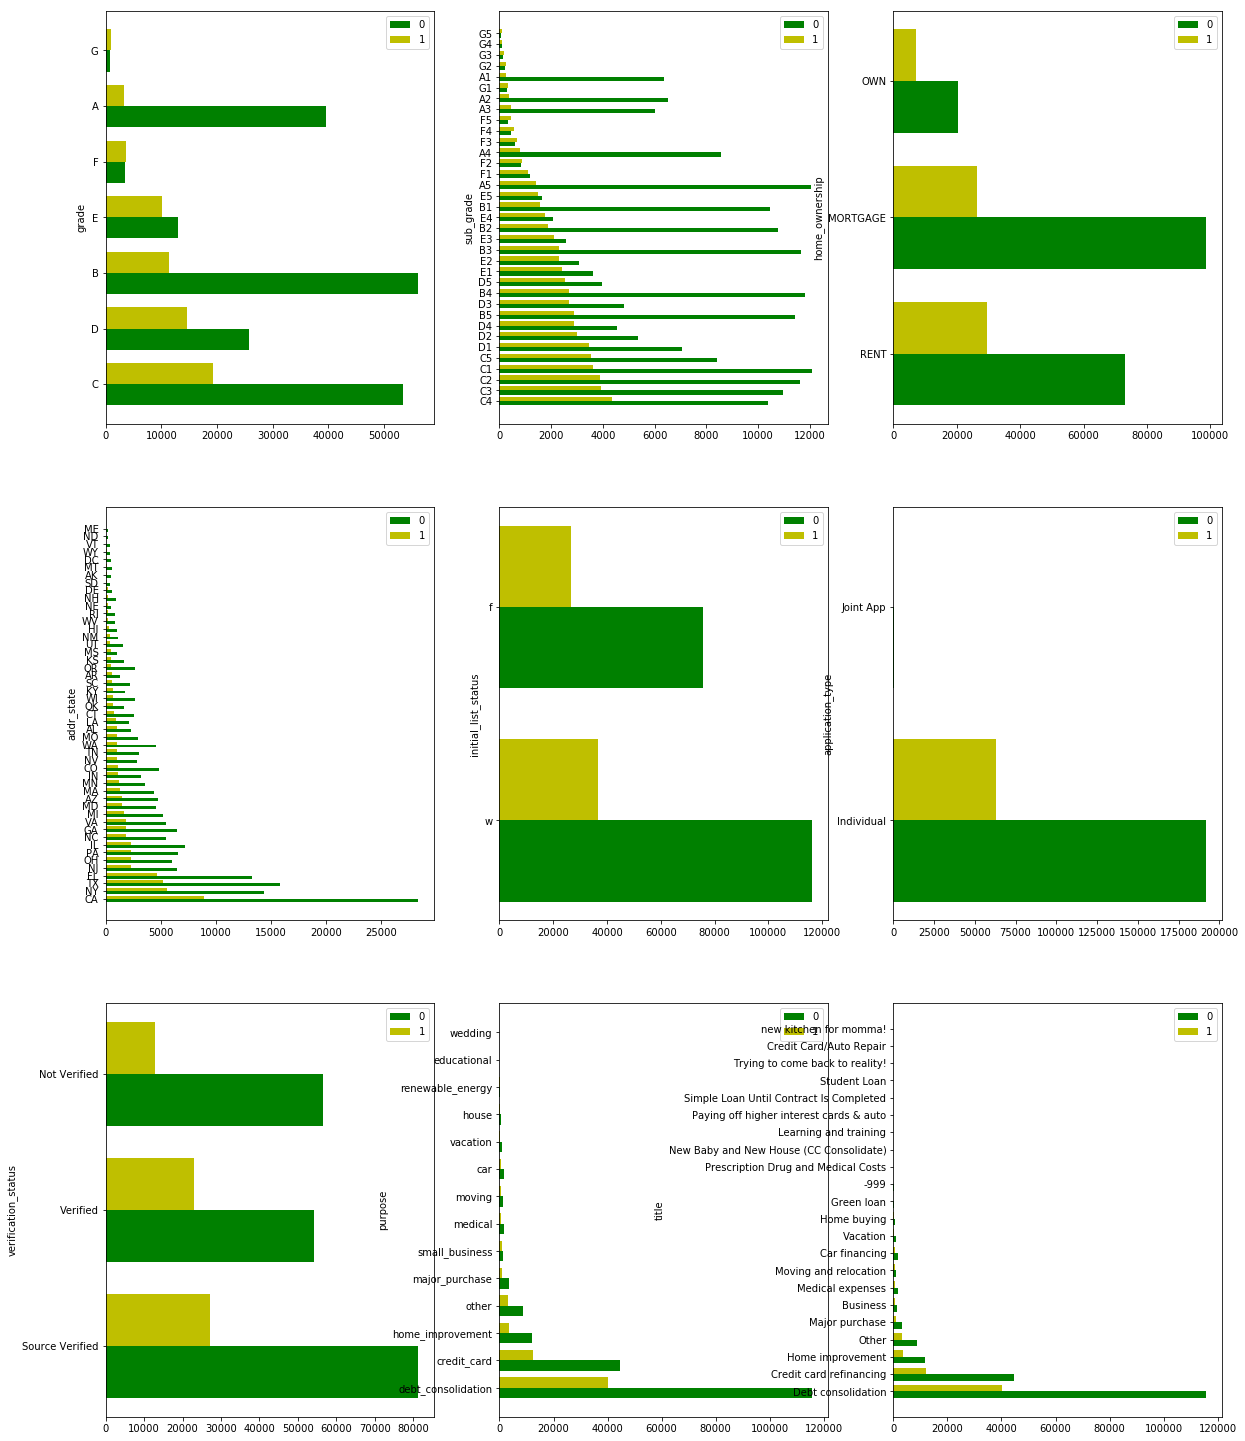

In [22]:
fig = plt.figure(figsize=(20,35))
for i in range(len(ll_object)-1):# exclude "emp_titile" for plot
    ax=fig.add_subplot(4, 3, i+1,)
    fea_df=dff[ll_object[i]]
    fea_ct=pd.crosstab(fea_df[fea_df!='-999'],dff.label).sort_values('1',ascending=False)
    width=0.38
    ind=np.arange(len(fea_ct.index))
    ax.barh(ind,fea_ct.iloc[:,0],width,color=['g'], label='0')
    ax.barh(ind+width,fea_ct.iloc[:,1],width,color=['y'], label='1')
    ax.set_ylabel(ll_object[i])
    ax.set_yticks(ind + width / 2)
    ax.set_yticklabels(fea_ct.index.tolist())
    ax.legend()
    plt.setp(ax.get_yticklabels(), fontsize=10)

#### Find most important categorical features using CatBoost

In [21]:
X=dff[l_float+l_int+ll_object]
#X=np.array(dff[l_int+ll_object])
Y=dff['label'].astype(int)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=33)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(204094, 65)
(51024, 65)
(204094,)
(51024,)


In [23]:
x_cat_train = x_train[l_int+ll_object]
x_cat_test = x_test[l_int+ll_object]

In [24]:
df_ = dff[l_int+ll_object]
cat_features_index = []
for col in ll_object:
    cat_features_index.append(df_.columns.tolist().index(col))

In [101]:
model = CatBoostClassifier(iterations=50,eval_metric='Accuracy',random_seed=42)

In [102]:
model.fit(x_cat_train,y_train,cat_features=cat_features_index)

0:	learn: 0.7407322	total: 572ms	remaining: 28s
1:	learn: 0.7375082	total: 1.28s	remaining: 30.8s
2:	learn: 0.7403794	total: 1.91s	remaining: 29.9s
3:	learn: 0.7413986	total: 2.5s	remaining: 28.7s
4:	learn: 0.7408057	total: 3.41s	remaining: 30.7s
5:	learn: 0.7406440	total: 4.45s	remaining: 32.6s
6:	learn: 0.7400953	total: 5.34s	remaining: 32.8s
7:	learn: 0.7409821	total: 6.13s	remaining: 32.2s
8:	learn: 0.7405999	total: 6.73s	remaining: 30.7s
9:	learn: 0.7405264	total: 7.5s	remaining: 30s
10:	learn: 0.7407371	total: 8.62s	remaining: 30.6s
11:	learn: 0.7406734	total: 9.54s	remaining: 30.2s
12:	learn: 0.7406244	total: 10.4s	remaining: 29.5s
13:	learn: 0.7407763	total: 11.2s	remaining: 28.7s
14:	learn: 0.7408792	total: 12.1s	remaining: 28.3s
15:	learn: 0.7411732	total: 13s	remaining: 27.6s
16:	learn: 0.7412859	total: 13.8s	remaining: 26.9s
17:	learn: 0.7412222	total: 14.7s	remaining: 26.2s
18:	learn: 0.7412565	total: 15.6s	remaining: 25.5s
19:	learn: 0.7416534	total: 16.4s	remaining: 24.7

In [103]:
cat_fea_imp = pd.DataFrame(model.feature_importances_,df_.columns,dtype=int,columns=['importance']).sort_values(by='importance',ascending=False)
cat_fea_imp[cat_fea_imp.importance>0]

,importance
grade,30
sub_grade,25
term,8
home_ownership,4
num_actv_rev_tl,3
avg_cur_bal,3
emp_title,3
mort_acc,2
tot_hi_cred_lim,2
num_rev_tl_bal_gt_0,2


> The most important categorical features are: grade, home_ownership, emp_title, verification_status, addr_state, title, purpose, application_type

#### Compute Chi2 for Categorical Features

In [104]:
X_cat = x_train[ll_object]

In [315]:
from scipy import stats

In [316]:
for i in range(len(ll_object)):
    contigency_tb = pd.crosstab(X_cat[ll_object[i]],y_train)
    chi2_tb = scipy.stats.chi2_contingency(contigency_tb)
    print(ll_object[i],chi2_tb[:3])

grade (16969.448847892123, 0.0, 6)
sub_grade (17710.71846171321, 0.0, 34)
home_ownership (1635.0671878727578, 0.0, 2)
addr_state (885.1197616585212, 1.8478639806992225e-154, 48)
initial_list_status (75.70184834798185, 3.2989866807754474e-18, 1)
application_type (4.328396103466913, 0.03748154862159736, 1)
verification_status (2026.877591091121, 0.0, 2)
purpose (540.208003498218, 6.051742222211321e-108, 12)
title (537.845279654256, 1.3214557675090828e-106, 13)
emp_title (1571.6162796135286, 3.1838783842944283e-201, 223)


In [108]:
for i in range(len(ll_object)):
    col_name = ll_object[i]
    dic = dict(X_cat[col_name].value_counts())
    X_cat[col_name] = X_cat[col_name].map(dic)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [109]:
from sklearn.feature_selection import SelectKBest, chi2

In [110]:
chi2(X_cat,y_train)

(array([1.96012521e+07, 4.32704920e+06, 2.21083280e+06, 5.87472041e+03,
        2.76552670e+05, 9.08566597e+02, 2.85527513e+05, 2.75579498e+06,
        2.77523320e+06, 2.95953932e+06]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.34758204e-199, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000]))

In [111]:
dict(zip(X_cat.columns,chi2(X_cat,y_train)[0]))

{'addr_state': 5874.720406415475,
 'application_type': 908.5665970593457,
 'emp_title': 2959539.3172437586,
 'grade': 19601252.089835726,
 'home_ownership': 2210832.79537509,
 'initial_list_status': 276552.6701960881,
 'purpose': 2755794.979953572,
 'sub_grade': 4327049.197676451,
 'title': 2775233.2031381577,
 'verification_status': 285527.5128894299}

In [112]:
dict(zip(X_cat.columns,chi2(X_cat,y_train)[1]))

{'addr_state': 0.0,
 'application_type': 1.347582041407297e-199,
 'emp_title': 0.0,
 'grade': 0.0,
 'home_ownership': 0.0,
 'initial_list_status': 0.0,
 'purpose': 0.0,
 'sub_grade': 0.0,
 'title': 0.0,
 'verification_status': 0.0}

> From the Chi2 test, all the categorical features are important 

#### Binning "title", "purpose"

In [25]:
x_train.purpose.unique()

array(['debt_consolidation', 'small_business', 'home_improvement',
       'other', 'credit_card', 'vacation', 'car', 'moving', 'medical',
       'major_purchase', 'house', 'renewable_energy', 'wedding'],
      dtype=object)

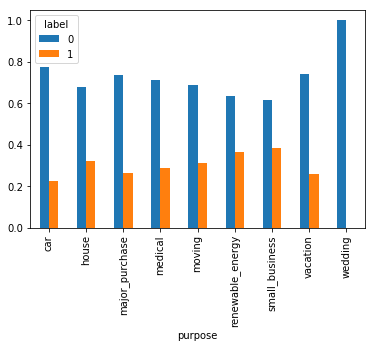

In [26]:
purp_subset=['major_purchase','small_business','medical','moving','car','vacation','house','renewable_energy','educational','wedding']
purp_ct=pd.crosstab(x_train.purpose[x_train.purpose.isin(purp_subset)],Y,normalize='index')#.sort_values(1,ascending=False)
purp_ct.plot(kind='bar')

In [27]:
pd.crosstab(x_train.purpose,Y).sort_values(1,ascending=False)

label,0,1
purpose,,
debt_consolidation,90402,34422
credit_card,34802,10526
home_improvement,9260,2966
other,6828,2663
major_purchase,2646,953
small_business,1057,655
medical,1383,554
moving,871,395
car,1302,376


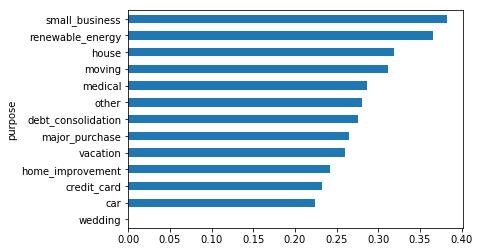

In [28]:
purpose_ct = pd.crosstab(x_train.purpose,Y).sort_values(1,ascending=False)
purpose_ct['default%'] = purpose_ct[1]/(purpose_ct[0] + purpose_ct[1])
purpose_ct['loan_amnt_med'] = x_train.groupby('purpose')['loan_amnt'].median()
purpose_ct['default%'].sort_values().plot(kind='barh')

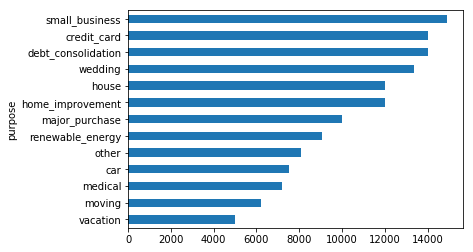

In [29]:
purpose_ct['loan_amnt_med'].sort_values().plot(kind='barh')

In [30]:
purpose_ct['rate'] = purpose_ct['default%']*purpose_ct['loan_amnt_med']

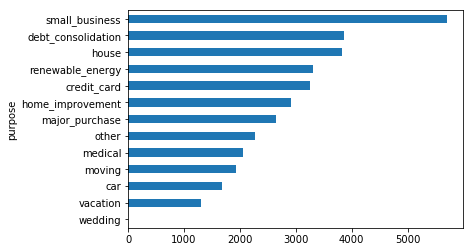

In [31]:
purpose_ct['rate'].sort_values().plot(kind='barh')

In [32]:
purp_subset=['medical','moving','car','vacation','house','renewable_energy','educational','wedding']

In [33]:
X.loc[X.purpose.isin(purp_subset),'purpose'] = 'other'

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [34]:
X.purpose.unique()

array(['debt_consolidation', 'home_improvement', 'other', 'credit_card',
       'small_business', 'major_purchase'], dtype=object)

In [35]:
X.drop('title',axis=1,inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=33)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(204094, 64)
(51024, 64)
(204094,)
(51024,)


In [37]:
x_train_vif = x_train[l_int+l_float]
x_train_vif = pd.concat([x_train_vif,y_train],axis=1)

In [169]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [198]:
x_train_vif.columns

Index(['loan_amnt', 'term', 'emp_length', 'zip_code', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
       'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'dur_y', 'int_rate', 'annual_inc',
       'installment', 'dti', 'r

In [226]:
#gather features
features = "+".join(x_train_vif.columns[:-1])  

# get y and X dataframes based on this regression:
y_vif, X_vif = dmatrices('label ~' + features, x_train_vif, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns

vif.round(1)

,VIF Factor,features
0,363.3,Intercept
1,64.2,loan_amnt
2,8.1,term
3,1.1,emp_length
4,1.0,zip_code
5,2.4,delinq_2yrs
6,1.3,inq_last_6mths
7,1.7,mths_since_last_delinq
8,453.3,open_acc
9,7.3,pub_rec


In [227]:
#gather features
features = "+".join(x_train_vif.columns[1:])  

# get y and X dataframes based on this regression:
y_vif, X_vif = dmatrices('loan_amnt ~' + features, x_train_vif, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif_ = pd.DataFrame()
vif_["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_["features"] = X_vif.columns

vif_.round(1)

,VIF Factor,features
0,322.7,Intercept
1,1.5,term
2,1.1,emp_length
3,1.0,zip_code
4,2.4,delinq_2yrs
5,1.3,inq_last_6mths
6,1.7,mths_since_last_delinq
7,453.3,open_acc
8,7.3,pub_rec
9,16.0,revol_bal


In [228]:
pd.merge(vif,vif_,on='features',how='outer')

,VIF Factor_x,features,VIF Factor_y
0,363.291064,Intercept,322.724389
1,64.210707,loan_amnt,NaN
2,8.128271,term,1.465885
3,1.071676,emp_length,1.073972
4,1.014861,zip_code,1.015105
5,2.385300,delinq_2yrs,2.386908
6,1.291341,inq_last_6mths,1.291478
7,1.706263,mths_since_last_delinq,1.706305
8,453.349785,open_acc,453.306837
9,7.298286,pub_rec,7.298175


In [248]:
def compute_vif(DataFrame):
    
    for i in range(0,DataFrame.shape[1]):
        
        feat_names = DataFrame.columns.tolist()
        feat_names.remove(DataFrame.columns[i])
        
        #gather features
        features = "+".join(feat_names)
        
        # get y and X dataframes based on this regression:
        y_vif, X_vif = dmatrices(DataFrame.columns[i] + '~' + features, DataFrame, return_type='dataframe')
        
        if i == 0:
            # For each X, calculate VIF and save in dataframe
            vif_df = pd.DataFrame()
            vif_df[DataFrame.columns[i]] = [variance_inflation_factor(X_vif.values, j) for j in range(X_vif.shape[1])]
            vif_df["features"] = X_vif.columns
        else:
            vif = pd.DataFrame()
            vif[DataFrame.columns[i]] = [variance_inflation_factor(X_vif.values, j) for j in range(X_vif.shape[1])]
            vif["features"] = X_vif.columns
            vif_df=pd.merge(vif_df,vif,on='features',how='outer')

        print(i+1,DataFrame.columns[i],'Done!')
        
    return vif_df

In [249]:
vif_df = compute_vif(x_train_vif)

1 loan_amnt Done!
2 term Done!
3 emp_length Done!
4 zip_code Done!
5 delinq_2yrs Done!
6 inq_last_6mths Done!
7 mths_since_last_delinq Done!
8 open_acc Done!
9 pub_rec Done!
10 revol_bal Done!
11 total_acc Done!
12 acc_now_delinq Done!
13 tot_coll_amt Done!
14 tot_cur_bal Done!
15 total_rev_hi_lim Done!
16 acc_open_past_24mths Done!
17 avg_cur_bal Done!
18 bc_open_to_buy Done!
19 chargeoff_within_12_mths Done!
20 mo_sin_old_il_acct Done!
21 mo_sin_old_rev_tl_op Done!
22 mo_sin_rcnt_rev_tl_op Done!
23 mo_sin_rcnt_tl Done!
24 mort_acc Done!
25 mths_since_recent_bc Done!
26 mths_since_recent_inq Done!
27 num_accts_ever_120_pd Done!
28 num_actv_bc_tl Done!
29 num_actv_rev_tl Done!
30 num_bc_sats Done!
31 num_bc_tl Done!
32 num_il_tl Done!
33 num_op_rev_tl Done!
34 num_rev_accts Done!
35 num_rev_tl_bal_gt_0 Done!
36 num_sats Done!
37 num_tl_120dpd_2m Done!
38 num_tl_30dpd Done!
39 num_tl_90g_dpd_24m Done!
40 num_tl_op_past_12m Done!
41 pub_rec_bankruptcies Done!
42 tax_liens Done!
43 tot_hi

In [250]:
vif_df.to_csv("vif.csv",index=False)

In [321]:
vif_mx = vif_df.set_index('features').drop('Intercept')
vif_mx = vif_mx.reindex_axis(sorted(vif_mx.columns), axis=0)
vif_mx = vif_mx.reindex_axis(sorted(vif_mx.columns), axis=1)
vif_mx.to_csv("vif_mx.csv")

In [295]:
for i in range(len(vif_mx.index)):
    for j in range(len(vif_mx.columns)):
        if vif_mx.iloc[i][j] <= 10:
            vif_mx.iloc[i][j] = 0
        else:
            pass
vif_mx

,acc_now_delinq,acc_open_past_24mths,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_2yrs,dti,dur_y,...,term,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,zip_code
features,,,,,,,,,,,,,,,,,,,,,
acc_now_delinq,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acc_open_past_24mths,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
annual_inc,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
avg_cur_bal,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bc_open_to_buy,10.198060,10.189627,10.182726,10.187604,NaN,10.186126,10.197930,10.196764,10.120942,10.198322,...,10.195114,10.197794,10.197894,10.194487,10.167412,10.185039,0.000000,10.184313,0.000000,10.198326
bc_util,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chargeoff_within_12_mths,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delinq_2yrs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dti,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [319]:
vif_mx[(vif_mx.acc_now_delinq != 0)].sort_values('acc_now_delinq',ascending=False)

,acc_now_delinq,acc_open_past_24mths,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_2yrs,dti,dur_y,...,term,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,zip_code
features,,,,,,,,,,,,,,,,,,,,,
open_acc,451.030805,453.358670,453.358079,453.330764,453.343913,453.354704,453.345388,453.352196,453.349621,453.353874,...,453.331914,453.328347,453.358390,453.356870,451.538516,453.333178,453.091055,453.359061,453.321129,453.345089
num_sats,450.374852,452.699138,452.695023,452.426663,452.677655,452.699630,452.693500,452.701610,452.695472,452.692527,...,452.685345,452.675955,452.686564,452.698437,451.010023,452.702477,452.468577,452.703329,452.619613,452.703362
tot_hi_cred_lim,96.990718,96.912280,96.599650,96.991801,96.955392,96.991920,96.987841,96.842713,96.729481,96.897634,...,96.981055,96.959407,0.000000,NaN,96.929203,76.602541,96.910515,78.019834,80.698976,96.940999
tot_cur_bal,94.128465,94.038529,93.961056,88.918848,94.126251,94.126658,94.126947,94.053455,93.669182,94.026039,...,94.129190,94.105151,NaN,0.000000,94.070498,75.838431,94.116051,79.264717,80.514914,94.077173
loan_amnt,64.226013,64.224689,64.199436,64.208436,64.164917,64.226019,64.225770,64.225261,64.216571,64.222442,...,11.551782,64.225686,64.225282,64.225335,64.225985,64.209394,63.881334,64.196160,64.225401,64.223511
installment,54.829621,54.828825,54.829484,54.792583,54.820117,54.829586,54.829423,54.829279,54.826184,54.827156,...,10.485800,54.829580,54.824697,54.829447,54.829327,54.828503,54.746063,54.828718,54.829587,54.829153
total_acc,46.382263,46.376760,46.375321,46.383599,46.243049,46.383419,46.381708,46.311014,46.376009,46.376892,...,46.383479,46.383644,46.354213,46.353668,NaN,46.333936,46.349572,46.323784,46.370305,46.380821
num_actv_rev_tl,43.961958,43.941454,43.968235,43.970479,42.706338,43.914649,43.970477,43.967416,43.969661,43.969266,...,43.967844,43.970479,43.963688,43.963042,43.918209,43.960636,43.748591,43.967883,43.329490,43.970144
num_rev_tl_bal_gt_0,41.153888,41.122693,41.143230,41.141566,39.561021,41.147999,41.158648,41.148902,41.089124,41.158695,...,41.152907,41.158158,41.153261,41.143901,41.148501,41.134209,40.380939,41.134681,40.409275,41.158824


In [38]:
delete_num_features = ['num_sats','tot_cur_bal','installment','total_acc','num_rev_tl_bal_gt_0','revol_bal','num_op_rev_tl','num_rev_accts','bc_open_to_buy']

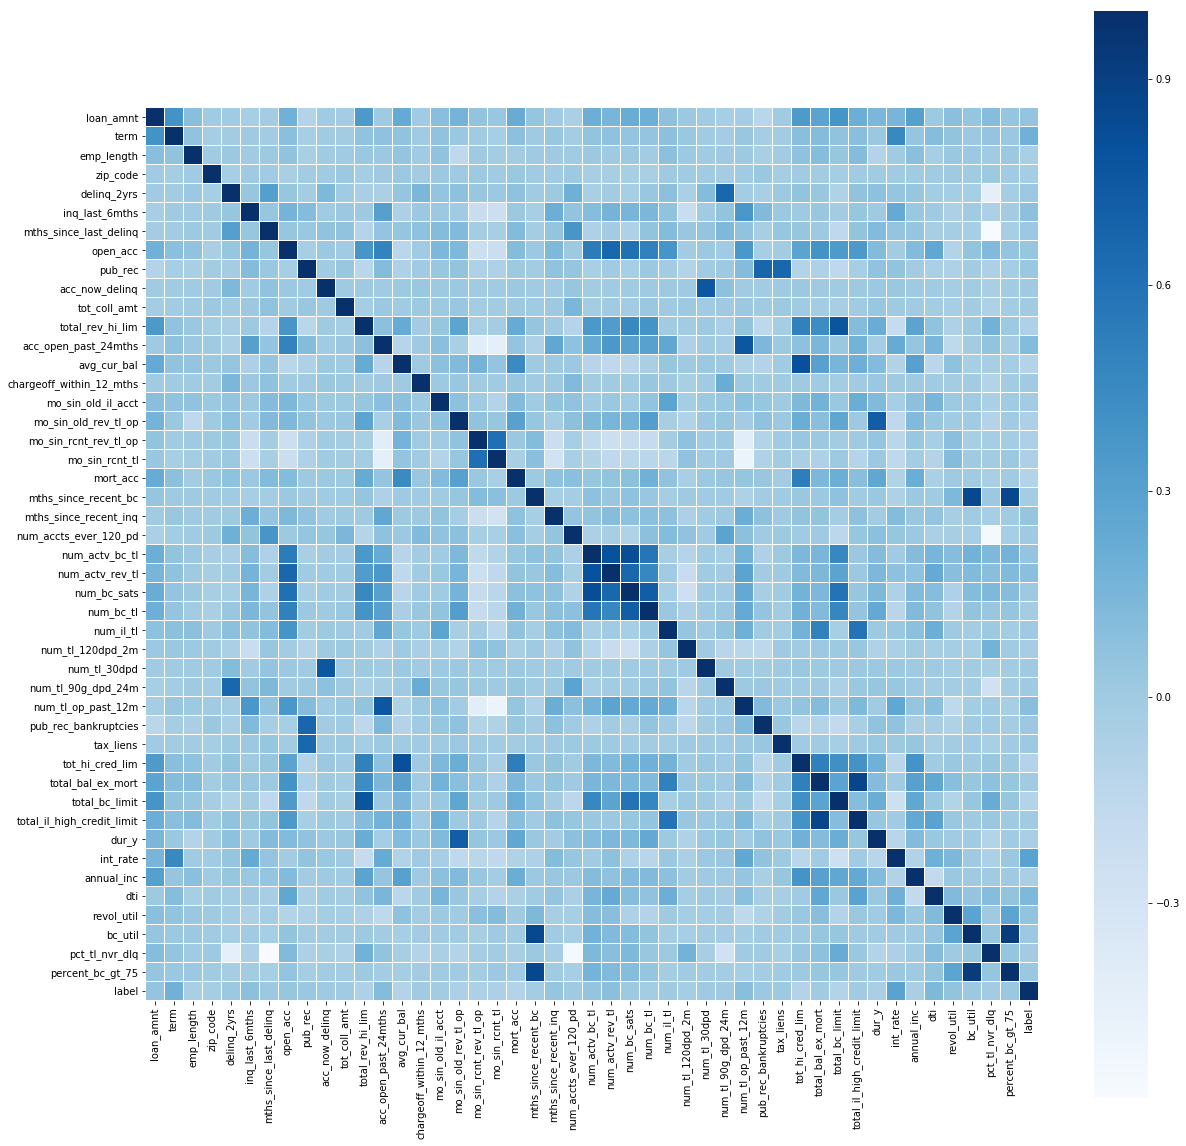

In [334]:
corr=x_train_vif.loc[:,x_train_vif.columns.isin(delete_num_features)==False].corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap=plt.cm.Blues,square=True,annot_kws={'size':8},linewidths=0.1)

In [39]:
# annual_inc to log(annual_inc)
X['log_inc'] = np.log10(X.annual_inc)
X.loc[np.isinf(X.log_inc)==True,'log_inc']=0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
# bin state
#plt.figure(figsize=(10,5)) 
state_ct = pd.crosstab(X.addr_state,Y).sort_values(1,ascending=False)
state_ct['default%'] = state_ct[1]/(state_ct[0] + state_ct[1])
#state_ct['default%'].sort_values().plot(kind='bar')
state_ct.sort_values('default%',ascending=False,inplace=True)
level_4 = state_ct[state_ct['default%']>=0.3].index.tolist()
level_3 = state_ct[(state_ct['default%']>=0.26)&(state_ct['default%']<0.3)].index.tolist()
level_2 = state_ct[(state_ct['default%']>=0.2)&(state_ct['default%']<0.26)].index.tolist()
level_1 = state_ct[state_ct['default%']<0.2].index.tolist()

In [41]:
X.loc[X.addr_state.isin(level_4),'addr_state'] = 'st_level_4'
X.loc[X.addr_state.isin(level_3),'addr_state'] = 'st_level_3'
X.loc[X.addr_state.isin(level_2),'addr_state'] = 'st_level_2'
X.loc[X.addr_state.isin(level_1),'addr_state'] = 'st_level_1'

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
delete_features = ['num_sats','tot_cur_bal','installment','total_acc',
                   'num_rev_tl_bal_gt_0','revol_bal','num_op_rev_tl',
                   'num_rev_accts','bc_open_to_buy','annual_inc','emp_title','sub_grade','title']

In [43]:
X_clean = X.loc[:,X.columns.isin(delete_features)==False]

In [44]:
X_dummy = pd.get_dummies(X_clean,drop_first=True,)

In [45]:
x_trn, x_tes, y_trn, y_tes = train_test_split(X_dummy,Y,test_size=0.2, random_state=33)

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_trn)
x_trn = scaler.transform(x_trn)
x_tes = scaler.transform(x_tes)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [48]:
lg = LogisticRegression()
lg.fit(np.array(x_trn),np.array(y_trn))
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_tes),lg.predict(np.array(x_tes)))
metrics.auc(fpr, tpr)

0.5692244427073211

In [70]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(np.array(x_trn),np.array(y_trn))
fpr, tpr, thresholds = metrics.roc_curve(y_trn,rfc.predict(x_trn))
print("Training Auc:",metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_tes),rfc.predict(np.array(x_tes)))
print("Test Auc:",metrics.auc(fpr, tpr))

Training Auc: 0.9620659047830321
Test Auc: 0.5550106199242224


In [50]:
from lightgbm import LGBMClassifier
#lgb_train = lgb.Dataset(x_trn, y_trn)
#lgb_eval = lgb.Dataset(x_tes, y_tes, reference=lgb_train)
lgb = LGBMClassifier()
lgb.fit(np.array(x_trn),np.array(y_trn))
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_tes),lgb.predict(np.array(x_tes)))
metrics.auc(fpr, tpr)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5777840597900383

In [51]:
from imblearn.over_sampling import SMOTE

In [67]:
sm = SMOTE(random_state=12,ratio=0.5)
x_trn_sm, y_trn_sm = sm.fit_sample(x_trn, y_trn)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [68]:
len(y_trn_sm[y_trn_sm==1])

75000

In [69]:
lgb.fit(x_trn_sm,y_trn_sm)
fpr, tpr, thresholds = metrics.roc_curve(y_trn_sm,lgb.predict(x_trn_sm))
print("Training Auc:",metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_tes),lgb.predict(np.array(x_tes)))
print("Test Auc:",metrics.auc(fpr, tpr))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training Auc: 0.6938966666666667
Test Auc: 0.5800669377041895


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
